<a href="https://colab.research.google.com/github/Hussien-Sayed/Earthquake-Modelling/blob/main/FFNN_classification_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Load the data

In [ ]:
!pip install contextily

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

import lightgbm as lgb
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Default Experiment config
n_clusters = 60
undersample = True

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EM/updated_minable_SEOD.csv")

## Cluster The Data

In [ ]:
def calculate_clustering(df,n_clusters=60, normalized=False,):
    """
    Function to calculate clustering of the dataframe based on latitude and longitude
    Args:
        df: Dataframe
        normalized: (Boolean). Whether to normalized data or not before the clustering.

    Returns:Dataframe with cluster_label as new column.

    """
    df.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
    coords = df[['latitude', 'longitude']]
    if normalized:
        scaler = MinMaxScaler()
        coords = scaler.fit_transform(coords)
    kmeans = KMeans(n_clusters =n_clusters , init ='k-means++')
    kmeans.fit(coords) # Compute k-means clustering.
    df['cluster_label'] = kmeans.fit_predict(coords)
    labels = kmeans.predict(coords) # Labels of each point
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    return df

In [ ]:
df = calculate_clustering(df,n_clusters=n_clusters, normalized=False)

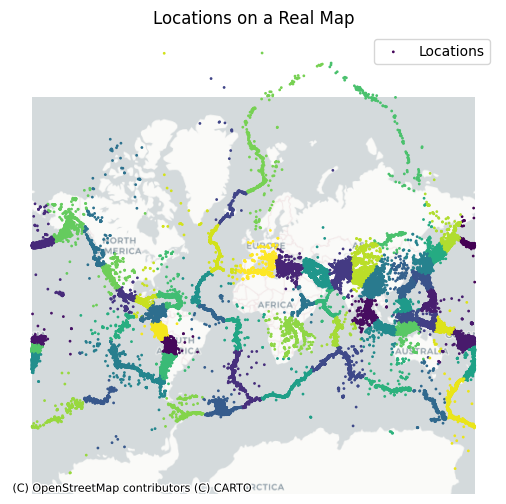

In [ ]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip") #"https://data.buffalony.gov/resource/d6g9-xbgu.geojson"

gdf = gpd.sjoin(gdf, world, how="left", predicate="within")

gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax,column='cluster_label', cmap='viridis', markersize=1, label="Locations")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # You can change the basemap provider
ax.set_title("Locations on a Real Map")
ax.legend()
ax.set_axis_off()
plt.show()


## Complete the Data

In [ ]:
#define day_frac
time_value = pd.to_datetime(df.time.apply(lambda x:x.split()[1]).apply(lambda x:x.split("+")[0]))
df["day_frac"] = (time_value.dt.hour * 3600 + time_value.dt.minute * 60 + time_value.dt.second)/ (24 * 60 * 60)


<ipython-input-9-2f802f072179>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_value = pd.to_datetime(df.time.apply(lambda x:x.split()[1]).apply(lambda x:x.split("+")[0]))


In [ ]:
# define a row for all clusters for all days
filled_data = df[['year','month','day']].copy()
filled_data.drop_duplicates(inplace=True)
filled_data_clusters = filled_data.loc[filled_data.index.repeat(n_clusters)].reset_index(drop=True)
filled_data_clusters["cluster_label"] = np.tile(np.arange(n_clusters), len(filled_data)).astype("int32")

#define cols to be merged with the filled_data_clusters
non_cluster_cols = df.columns.difference(['latitude', 'longitude', 'depth', 'mag','cluster_label',"time","day_frac"])

#,'ill_frac_interpolated','r/km_interpolated', 'dec_interpolated','ra/h_interpolated',
#'ra/°_interpolated', 'td_acc_interpolated',

#define cols to be aggregated
cluster_cols = df.columns.difference(non_cluster_cols).tolist() + ['year','month','day']
cluster_cols.remove("time")

filled_data_clusters = filled_data_clusters.merge(df[non_cluster_cols].drop_duplicates(),how ="left",on=['year','month','day'])
n_earthquakes = df[cluster_cols].groupby(['year','month','day','cluster_label']).day.count().rename("n_earthquakes")
agg_df_per_cluster = df[cluster_cols].groupby(['year','month','day','cluster_label']).mean()
agg_df_per_cluster = pd.concat((agg_df_per_cluster,n_earthquakes),axis=1).reset_index()
filled_data_clusters = filled_data_clusters.merge(agg_df_per_cluster,how ="left",on=['year','month','day','cluster_label'])

filled_data_clusters["mag"] = filled_data_clusters["mag"].fillna(0)
filled_data_clusters["n_earthquakes"] = filled_data_clusters["n_earthquakes"].fillna(0)
nan_cols = filled_data_clusters.columns[filled_data_clusters.isna().any(axis=0)]

filled_data_clusters[nan_cols] = filled_data_clusters[nan_cols].fillna(filled_data_clusters.groupby(['year','month','day'])[nan_cols].transform('mean'))

# inverse clusters to sample locations for generated data of non-existing Earthquakes
for cluster_ix in tqdm(filled_data_clusters.cluster_label.unique()):
    df_to_fill_ix = (filled_data_clusters["cluster_label"] == cluster_ix)&(filled_data_clusters["n_earthquakes"] == 0)
    df_from_fill_ix = (filled_data_clusters["cluster_label"] == cluster_ix)&(filled_data_clusters["n_earthquakes"] != 0)
    n_samples = sum(df_to_fill_ix)
    filled_data_clusters.loc[df_to_fill_ix, ["latitude","longitude"] ] = \
    filled_data_clusters.loc[df_from_fill_ix, ["latitude","longitude"] ].sample(n_samples,replace=True).values

#define random values for day_frac of non-existing Earthquakes
filled_data_clusters.loc[filled_data_clusters.mag==0,"day_frac"] = np.random.rand((filled_data_clusters.mag==0).sum())

#define intrp values
delta = filled_data_clusters[['ill_frac_1','r/km_1','dec_1','ra/h_1','ra/°_1','td_acc_1']].values - filled_data_clusters[['ill_frac','r/km','dec','ra/h','ra/°','td_acc']].values
filled_data_clusters[['ill_frac_interpolated','r/km_interpolated','dec_interpolated','ra/h_interpolated','ra/°_interpolated','td_acc_interpolated']] = filled_data_clusters[['ill_frac','r/km','dec','ra/h','ra/°','td_acc']].values + delta * filled_data_clusters.day_frac.values.reshape(-1,1)


#remove range(4.5-4.8) from being considered as earthquake
filled_data_clusters.loc[filled_data_clusters.mag<4.8,"n_earthquakes"] = 0
filled_data_clusters.loc[filled_data_clusters.mag<4.8,"mag"] = 0

#fill 0 values eathquake magnitude with a distribution for un noticed earthquake magnitudes
#ix1 = np.arange(0,1.7,0.00671)
#ix2 = np.arange(1.7,4.5,0.00671)

#val1 = [3.5]*len(ix1)
#val2 = np.linspace(3.5,1,len(ix2))
#ix = np.hstack((ix1,ix2))
#val = np.hstack((val1,val2))
#val = np.power(10,val)

#gen_dist = []
#for i,v in zip(ix,val):
#    gen_dist.extend([i]*int(v))
#np.random.shuffle(gen_dist)

#filled_data_clusters.loc[filled_data_clusters.mag==0,"mag"] = gen_dist[:(filled_data_clusters.mag==0).sum()]
filled_data_clusters.loc[filled_data_clusters.mag==0,"mag"] = 2.4  #median value


#add date
tot_sec = filled_data_clusters["day_frac"] * 24 * 60 * 60
#filled_data_clusters["hour"] = tot_sec//(60*60)
#filled_data_clusters["minute"] = tot_sec%(60*60)//60
#filled_data_clusters["second"] = tot_sec%60
#filled_data_clusters['date'] = pd.to_datetime(filled_data_clusters[['year', 'month', 'day','hour','minute','second']])


100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


In [ ]:
# remove useless columns
filled_data_clusters.drop(['dec', 'dec_1',
 'ill_frac', 'ill_frac_1',
 'r/km', 'r/km_1',
 'ra/h', 'ra/h_1',
 'ra/°','ra/°_1',
 'td_acc', 'td_acc_1',
 ],axis=1,inplace=True)



## NN Model

In [ ]:
batch_size = 2048
lr = 0.001
num_epochs = 20
in_shape = 14


In [ ]:
exclude_from_train = ['depth', 'mag', 'n_earthquakes']
X = filled_data_clusters[filled_data_clusters.columns.difference(exclude_from_train)].copy().fillna(0)
y = filled_data_clusters['mag'].copy()
y = (y>=4.8).astype("int")

X_test  = X[X.year>=2015].copy()
y_test = y[X.year>=2015].copy()

X_tv = X[X.year<2015].copy()
y_tv = y[X.year<2015].copy()


if undersample:
    ix_org = y_tv==1
    ix_gen = y_tv==0

    n_samples = sum(ix_org)
    ix_gen_sampled = y_tv[ix_gen].sample(n_samples).index
    ix_org = y_tv[ix_org].index

    full_ix = ix_gen_sampled.append(ix_org)

    X_tv = X_tv.loc[full_ix]
    y_tv = y_tv.loc[full_ix]
    X_tv = X_tv.sample(frac=1)
    y_tv = y_tv.sample(frac=1)

X_train, X_val, y_train, y_val = train_test_split(X_tv,y_tv, test_size=0.2, random_state=42)


In [ ]:
# define model
class NN_model(nn.Module):

    def __init__(self,in_shape):
        super(NN_model,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_shape,64),
            nn.ReLU(),

            nn.Linear(64,16),
            nn.ReLU(),

            nn.Linear(16,4),
            nn.ReLU(),

            nn.Linear(4,1),
            nn.Sigmoid()

            )

    def forward(self,x):
        x = self.model(x)
        return x



model = NN_model(in_shape)
if torch.cuda.is_available():
  model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2,factor=0.1)

loss_fn = nn.BCELoss()

In [ ]:
# train loop
all_train_loss  = []
model.train()

train_dataset = TensorDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,drop_last=True)

val_dataset = TensorDataset(torch.tensor(X_val.values), torch.tensor(y_val.values))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True,drop_last=True)


for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])

  #train
  losses=[]
  model.train()
  for batch_X, batch_y in train_loader:
    if torch.cuda.is_available():
      batch_X = batch_X.cuda()
      batch_y = batch_y.cuda()
    preds = model(batch_X.float())
    optimizer.zero_grad()
    loss = loss_fn(preds,batch_y.reshape(-1,1).float())
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())


  model.eval()
  y_pred_proba = []
  y_val_label = []
  val_losses = []
  for batch_X, batch_y in val_loader:
    if torch.cuda.is_available():
      batch_X = batch_X.cuda()
      batch_y = batch_y.cuda()
    preds = model(batch_X.float())

    loss = loss_fn(preds,batch_y.reshape(-1,1).float())
    val_losses.append(loss.detach().cpu())

    y_pred_proba.append(preds.detach().cpu().numpy())
    y_val_label.append(batch_y.detach().cpu().numpy())

  y_pred_proba = np.array(y_pred_proba)
  y_pred_proba = np.squeeze(y_pred_proba, axis=-1)
  y_val_label = np.array(y_val_label)


  thresholds = np.linspace(0, 1, 100)  # Vary threshold from 0 to 1
  accuracies = []

  for t in thresholds:
      y_pred = (y_pred_proba >= t).astype(int)  # Apply threshold
      accuracies.append(accuracy_score(y_val_label.flatten(), y_pred.flatten()))

  # Find the best threshold
  best_threshold = thresholds[np.argmax(accuracies)]
  best_accuracy = max(accuracies)

  print("best acc",best_accuracy)
  print("best threshold",best_threshold)
  print("val loss",np.mean(val_losses))


  scheduler.step(np.mean(val_losses))

---------- Epoch :1/20 ----------
learning rate:  0.001
best acc 0.4999080882352941
best threshold 0.0
val loss 50.00919
---------- Epoch :2/20 ----------
learning rate:  0.001
best acc 0.5000919117647059
best threshold 0.5050505050505051
val loss 0.69315493
---------- Epoch :3/20 ----------
learning rate:  0.001
best acc 0.5001225490196078
best threshold 0.5050505050505051
val loss 0.6931833
---------- Epoch :4/20 ----------
learning rate:  0.001
best acc 0.5001225490196078
best threshold 0.5050505050505051
val loss 0.69314754
---------- Epoch :5/20 ----------
learning rate:  0.001
best acc 0.5001531862745098
best threshold 0.5050505050505051
val loss 0.6931763
---------- Epoch :6/20 ----------
learning rate:  0.0001
best acc 0.5000306372549019
best threshold 0.0
val loss 0.69315064
---------- Epoch :7/20 ----------
learning rate:  0.0001
best acc 0.5001531862745098
best threshold 0.5050505050505051
val loss 0.69314915
---------- Epoch :8/20 ----------
learning rate:  0.0001
best acc 

In [ ]:
#testing
val_dataset = TensorDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)


model.eval()
y_pred_proba = []
y_val_label = []
val_losses = []
for batch_X, batch_y in val_loader:
  if torch.cuda.is_available():
    batch_X = batch_X.cuda()
    batch_y = batch_y.cuda()
  preds = model(batch_X.float())

  loss = loss_fn(preds,batch_y.reshape(-1,1).float())
  val_losses.append(loss.detach().cpu())

  y_pred_proba.append(preds.detach().cpu().numpy())
  y_val_label.append(batch_y.detach().cpu().numpy())

y_pred_proba = np.array(y_pred_proba)
y_pred_proba = np.squeeze(y_pred_proba, axis=-1)
y_val_label = np.array(y_val_label)


thresholds = np.linspace(0, 1, 100)  # Vary threshold from 0 to 1
accuracies = []

for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)  # Apply threshold
    accuracies.append(accuracy_score(y_val_label.flatten(), y_pred.flatten()))

# Find the best threshold
best_threshold = thresholds[np.argmax(accuracies)]
best_accuracy = max(accuracies)

print("best acc",best_accuracy)
print("best threshold",best_threshold)
print("val loss",np.mean(val_losses))



best acc 0.9042886840202459
best threshold 0.5050505050505051
val loss 0.6934708
